In [ ]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

import geopandas as gpd
from eodag import EODataAccessGateway
import rioxarray as riox
import folium
from folium import LayerControl
from eo_tools_dev.util import show_cog
from eo_tools.S1.process import goldstein

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
log = logging.getLogger(__name__)

In [ ]:
# change to your custom locations
data_dir = "/data/S1"

ids = ['S1A_IW_SLC__1SDV_20181228T050448_20181228T050515_025221_02C9BE_1E22',
 'S1B_IW_SLC__1SDV_20181222T050400_20181222T050427_014150_01A4AE_4A45']
primary_dir = f"{data_dir}/{ids[0]}.SAFE"
secondary_dir = f"{data_dir}/{ids[1]}.SAFE"
outputs_prefix="/data/res/goldstein-etna"

## Download S-1 products

In [ ]:
# load a geometry
file_aoi = "../data/Etna.geojson"
shp = gpd.read_file(file_aoi).geometry[0]

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2023-09-03",
    "end": "2023-09-17",
    "geom": shp
}

results, _ = dag.search(**search_criteria)
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
# dag.download_all(to_dl, outputs_prefix="/data/S1/", extract=False)

## Pre-process InSAR pair

In [ ]:
from eo_tools.S1.process import prepare_insar

out_dir = prepare_insar(
    dir_prm=primary_dir,
    dir_sec=secondary_dir,
    outputs_prefix=outputs_prefix,
    aoi_name=None,
    shp=shp,
    pol="vv",
    subswaths=["IW1", "IW2", "IW3"],
    cal_type="beta",
    apply_fast_esd=True,
    dem_upsampling=1.8,
    dem_buffer_arc_sec=40,
    warp_kernel="bicubic",
)

## Apply processing chains: interferogram and Goldstein filter 

In [ ]:
from pathlib import Path
out_dir = list(Path.glob(Path(outputs_prefix), 'S1*'))[0] / 'sar'

In [49]:
from eo_tools.S1.process import interferogram
from eo_tools.S1.process import apply_to_patterns_for_pair, apply_to_patterns_for_single
from pathlib import Path
geo_dir = Path(out_dir).parent

# compute interferograms
# apply_to_patterns_for_pair(
#     interferogram,
#     out_dir=out_dir,
#     file_prm_prefix="slc_prm",
#     file_sec_prefix="slc_sec",
#     file_out_prefix="ifg0",
#     multilook=[1,4]
# )

# apply Goldstein filter
apply_to_patterns_for_single(
    goldstein,
    out_dir=out_dir,
    file_in_prefix="ifg0",
    file_out_prefix="ifg",
    alpha=0.7,
    overlap=20
)

INFO:eo_tools.S1.process:Apply 'goldstein' to ifg0_vv_iw2.tif


INFO:eo_tools.S1.process:File ifg_vv_iw2.tif written


## Apply geocoding, merge and crop subswaths

In [50]:
from eo_tools.S1.process import geocode_and_merge_iw
from pathlib import Path
out_dir = list(Path.glob(Path(outputs_prefix), 'S1*'))[0] / 'sar'
geo_dir = Path(out_dir).parent
# geocode_and_merge_iw(geo_dir, shp=shp, var_names=["ifg0", "ifg"], clip_to_shape=True)
geocode_and_merge_iw(geo_dir, shp=shp, var_names=["ifg"], clip_to_shape=True)

INFO:eo_tools.S1.process:Geocode file ifg_vv_iw2.tif.
INFO:eo_tools.S1.process:Project image with the lookup table.


INFO:eo_tools.S1.process:Merge file phi_vv.tif
INFO:eo_tools.auxils:Removing /data/res/goldstein-etna/S1_InSAR_2018-12-28-050448__2018-12-22-050400/sar/phi_vv_iw2_geo.tif


## Visualize
Compare the filtered version with the orginal one.  
Click on top right icon to hide/show layers.  


In [51]:
from eo_tools_dev.util import palette_phi
m = folium.Map()
# _ = show_cog(f"{geo_dir}/phi0_vv.tif", m, rescale="-3.14,3.14", colormap=palette_phi())
# _ = show_cog(f"{geo_dir}/phi_vv.tif", m, rescale="-3.14,3.14", colormap=palette_phi())
_ = show_cog(f"{geo_dir}/phi_vv.tif", m, rescale="-3.14,3.14", colormap_name="jet", resample="nearest")
LayerControl().add_to(m)
m

INFO:httpx:HTTP Request: GET http://localhost:8085/cog/info?url=%2Fdata%2Fres%2Fgoldstein-etna%2FS1_InSAR_2018-12-28-050448__2018-12-22-050400%2Fphi_vv.tif "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: GET http://localhost:8085/cog/tilejson.json?url=%2Fdata%2Fres%2Fgoldstein-etna%2FS1_InSAR_2018-12-28-050448__2018-12-22-050400%2Fphi_vv.tif&port=8085&rescale=-3.1399999979619455%2C%203.14&colormap_name=jet&resample=nearest "HTTP/1.1 200 OK"


In [40]:
import rasterio
with rasterio.open(f"{out_dir}/ifg_vv_iw2.tif") as ds:
    arr = ds.read(1)
    print(ds.profile)# 
with rasterio.open(f"{out_dir}/ifg0_vv_iw2.tif") as ds:
    arr0 = ds.read(1)
    print(ds.profile)# 

{'driver': 'GTiff', 'dtype': 'complex64', 'nodata': nan, 'width': 6527, 'height': 2858, 'count': 1, 'crs': None, 'transform': Affine(4.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'complex64', 'nodata': nan, 'width': 6527, 'height': 2858, 'count': 1, 'crs': None, 'transform': Affine(4.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'interleave': 'band'}


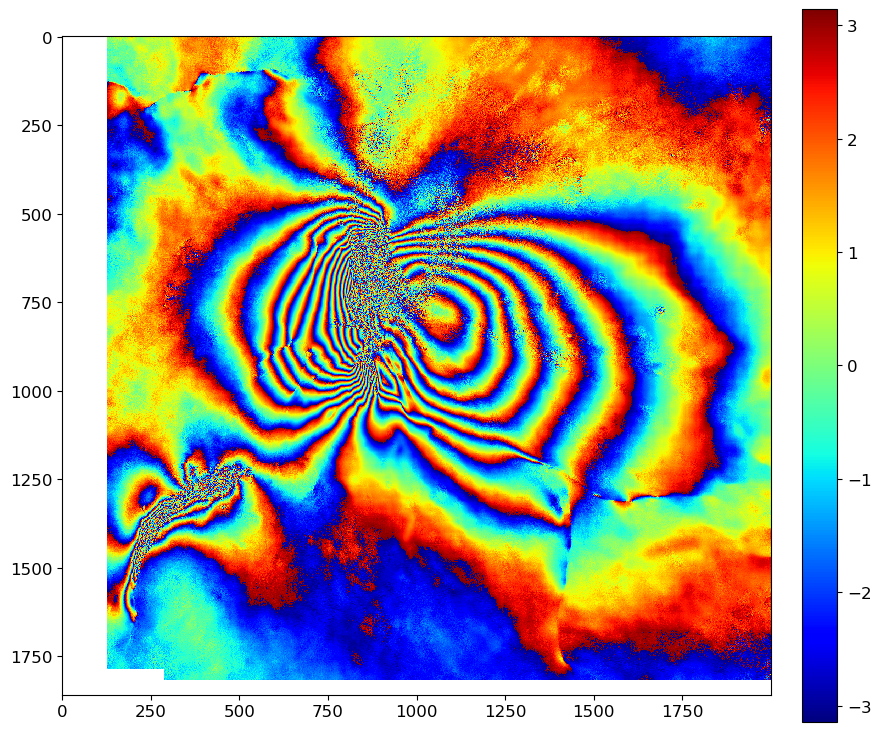

In [45]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(np.angle(arr[1000:, :2000]), interpolation="none", cmap="twilight")
plt.colorbar(fraction=0.046, pad=0.04)

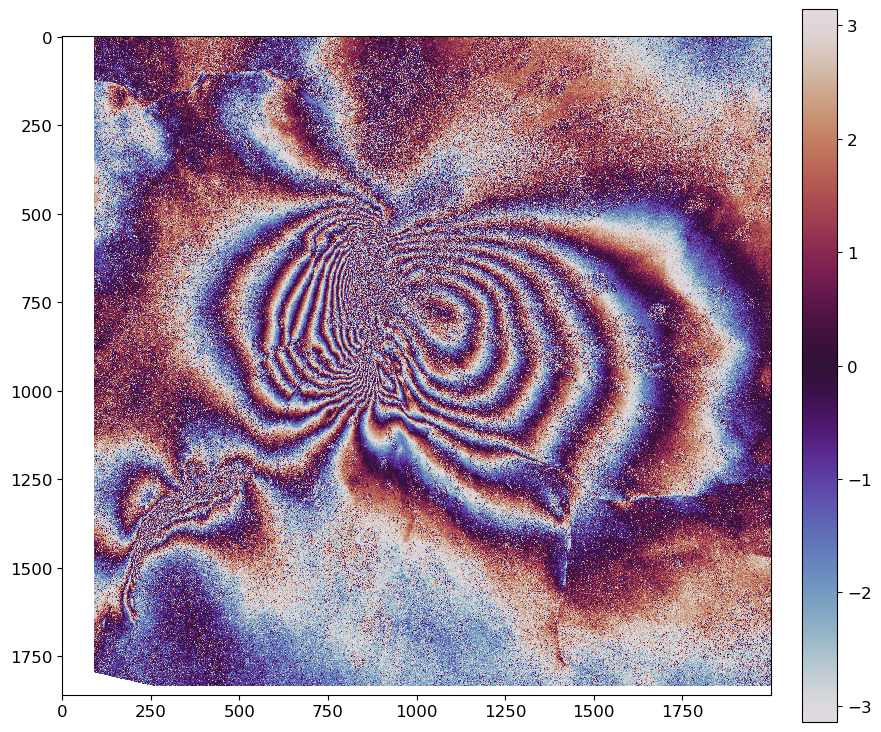

In [30]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(np.angle(arr0[1000:, :2000]), interpolation="none", cmap="twilight")
plt.colorbar(fraction=0.046, pad=0.04)